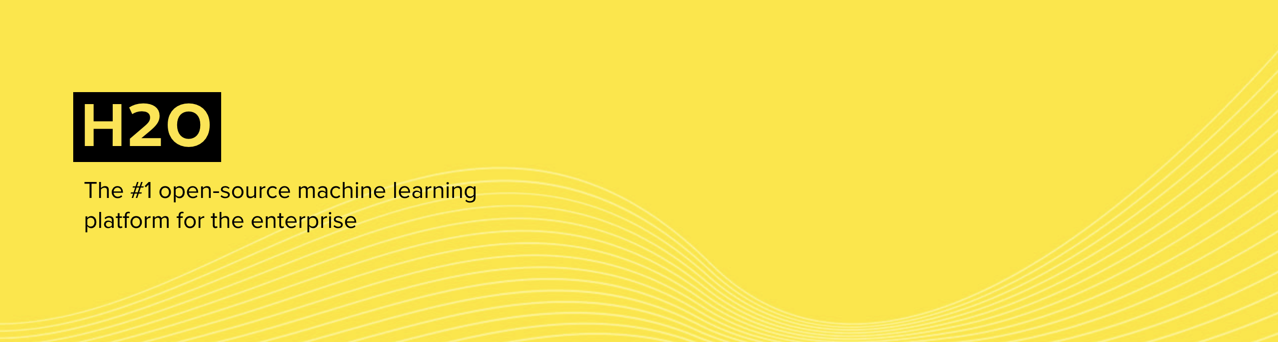

## License 

<span style="color:gray"> Copyright 2022 David Whiting and Greg Keys

<span style="color:gray"> Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

<span style="color:gray">     http://www.apache.org/licenses/LICENSE-2.0

<span style="color:gray"> Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<span style="color:gray"> **DISCLAIMER:** This notebook is not legal compliance advice. </span>

<hr style="background-color: gray;height: 2.0px;"/>

# Chapter 5 - Lending Club

## Start the H2O-3 cluster

We start the cluster assuming it is locally installed. Your startup commands will depend on your setup. _See Appendix A for details._

Your numeric results may vary somewhat from that shown in the text if the H2O cluster version or the number of nodes and cores available to the H2O server are different from what was used in the book.

In [1]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "14.0.2" 2020-07-14; Java(TM) SE Runtime Environment (build 14.0.2+12-46); Java HotSpot(TM) 64-Bit Server VM (build 14.0.2+12-46, mixed mode, sharing)
  Starting server from /Users/david/local/miniconda3/envs/packt/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/vc/p3y1h0bs6tv7n439qrgmq9980000gq/T/tmp5hkiuqr3
  JVM stdout: /var/folders/vc/p3y1h0bs6tv7n439qrgmq9980000gq/T/tmp5hkiuqr3/h2o_david_started_from_python.out
  JVM stderr: /var/folders/vc/p3y1h0bs6tv7n439qrgmq9980000gq/T/tmp5hkiuqr3/h2o_david_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,30 days
H2O_cluster_name:,H2O_from_python_david_x5qf4f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


## Import data

In [2]:
#input_csv = "https://github.com/PacktPublishing/Machine-Learning-at-Scale-with-H2O/chapt5/loans.csv"
input_csv = "https://s3.amazonaws.com/data.h2o.ai/Machine-Learning-at-Scale/lending_club/loans.csv"

loans = h2o.import_file(input_csv)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [3]:
loans.dim

[38980, 16]

In [4]:
loans.head()

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,credit_length
5000,36 months,10.65,10,RENT,24000,verified,1.3227e+12,credit_card,AZ,27.65,0,83.7,9,0,26
2500,60 months,15.27,0,RENT,30000,verified,1.3227e+12,car,GA,1,0,9.4,4,1,12
2400,36 months,15.96,10,RENT,12252,not verified,1.3227e+12,small_business,IL,8.72,0,98.5,10,0,10
10000,36 months,13.49,10,RENT,49200,verified,1.3227e+12,other,CA,20,0,21,37,0,15
5000,36 months,7.9,3,RENT,36000,verified,1.3227e+12,wedding,AZ,11.2,0,28.3,12,0,7
3000,36 months,18.64,9,RENT,48000,verified,1.3227e+12,car,CA,5.35,0,87.5,4,0,4
5600,60 months,21.28,4,OWN,40000,verified,1.3227e+12,small_business,CA,5.55,0,32.6,13,1,7
5375,60 months,12.69,0,RENT,15000,verified,1.3227e+12,other,TX,18.08,0,36.5,3,1,7
6500,60 months,14.65,5,OWN,72000,not verified,1.3227e+12,debt_consolidation,AZ,16.12,0,20.6,23,0,13
12000,36 months,12.69,10,OWN,75000,verified,1.3227e+12,debt_consolidation,CA,10.78,0,67.1,34,0,22


In [5]:
loans["bad_loan"] = loans["bad_loan"].asfactor()

In [6]:
loans["issue_d_year"] = loans["issue_d"].year().asfactor()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()

## Splitting data


### Traditional train, validate, and test set splits


In [7]:
train, valid, test = loans.split_frame(
    seed = 25,
    ratios = [0.6, 0.2],
    destination_frames = ["train", "valid", "test"])

### Train and test split for k-fold cross validation

In [8]:
train_cv, test_cv = loans.split_frame(
    seed = 25,                        
    ratios = [0.8],                                      
    destination_frames = ["train_cv", "test_cv"]
)

## Baseline Model Training

In [9]:
response = "bad_loan"
omit = ["issue_d", response]
predictors = list(set(loans.columns) - set(omit))

### Baseline GBM train-validate-test model

In [10]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm = H2OGradientBoostingEstimator(seed = 25)
gbm.train(x = predictors,
          y = response,
          training_frame = train,
          validation_frame = valid,
          model_id = "gbm_baseline")

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_baseline


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,25099.0,5.0,5.0,5.0,17.0,32.0,28.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10439619983523844
RMSE: 0.323104007767218
LogLoss: 0.3442076458354961
Mean Per-Class Error: 0.2813394331209395
AUC: 0.8264100301886944
AUCPR: 0.557378730541788
Gini: 0.6528200603773888

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2567501506428664: 


,,0,1,Error,Rate
0,0,17703.0,2000.0,0.1015,(2000.0/19703.0)
1,1,1740.0,2033.0,0.4612,(1740.0/3773.0)
2,Total,19443.0,4033.0,0.1593,(3740.0/23476.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.256750,0.520881,185.0
1,max f2,0.146769,0.615068,270.0
2,max f0point5,0.365991,0.553303,125.0
3,max accuracy,0.402041,0.867184,110.0
4,max precision,0.962235,1.000000,0.0
5,max recall,0.030916,1.000000,388.0
6,max specificity,0.962235,1.000000,0.0
7,max absolute_mcc,0.290534,0.426969,164.0
8,max min_per_class_accuracy,0.170853,0.741055,249.0
9,max mean_per_class_accuracy,0.180535,0.742964,242.0



Gains/Lift Table: Avg response rate: 16.07 %, avg score: 16.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.611237,5.957334,5.957334,0.957447,0.687928,0.957447,0.687928,0.059634,0.059634,495.733403,495.733403,0.059127
1,2,0.020020,0.537543,5.215977,5.586655,0.838298,0.570906,0.897872,0.629417,0.052213,0.111847,421.597690,458.665546,0.109411
2,3,0.030031,0.486934,4.686436,5.286582,0.753191,0.511122,0.849645,0.589985,0.046912,0.158760,368.643610,428.658234,0.153380
3,4,0.040041,0.451636,4.474620,5.083592,0.719149,0.468713,0.817021,0.559667,0.044792,0.203552,347.461978,408.359170,0.194822
4,5,0.050009,0.424924,3.563085,4.780527,0.572650,0.437074,0.768313,0.535232,0.035516,0.239067,256.308544,378.052657,0.225262
5,6,0.100017,0.329193,2.920255,3.850391,0.469336,0.372139,0.618825,0.453685,0.146038,0.385105,192.025514,285.039086,0.339680
6,7,0.150026,0.275002,2.236566,3.312449,0.359455,0.300399,0.532368,0.402590,0.111847,0.496952,123.656565,231.244912,0.413361
7,8,0.200034,0.235718,1.695974,2.908330,0.272572,0.254101,0.467419,0.365468,0.084813,0.581765,69.597395,190.833033,0.454830
8,9,0.300009,0.184735,1.232756,2.349964,0.198125,0.208301,0.377680,0.313094,0.123244,0.705009,23.275610,134.996419,0.482556
9,10,0.400026,0.149818,0.930136,1.994969,0.149489,0.166140,0.320626,0.276352,0.093029,0.798039,-6.986429,99.496927,0.474230




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.12387962121385686
RMSE: 0.3519653693388838
LogLoss: 0.4005986897473847
Mean Per-Class Error: 0.33559788779727173
AUC: 0.7204978140549837
AUCPR: 0.333202223041529
Gini: 0.4409956281099674

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1699389851405903: 


,,0,1,Error,Rate
0,0,4630.0,1911.0,0.2922,(1911.0/6541.0)
1,1,481.0,788.0,0.379,(481.0/1269.0)
2,Total,5111.0,2699.0,0.3063,(2392.0/7810.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169939,0.397177,239.0
1,max f2,0.107599,0.542603,300.0
2,max f0point5,0.305263,0.375231,139.0
3,max accuracy,0.531806,0.838412,41.0
4,max precision,0.751003,0.600000,4.0
5,max recall,0.025797,1.000000,391.0
6,max specificity,0.792153,0.999847,0.0
7,max absolute_mcc,0.169939,0.255056,239.0
8,max min_per_class_accuracy,0.154076,0.660908,254.0
9,max mean_per_class_accuracy,0.163881,0.664650,245.0



Gains/Lift Table: Avg response rate: 16.25 %, avg score: 15.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010115,0.564217,3.194083,3.194083,0.518987,0.638585,0.518987,0.638585,0.032309,0.032309,219.408285,219.408285,0.026499
1,2,0.020102,0.498629,2.998323,3.096826,0.487179,0.526829,0.503185,0.583063,0.029945,0.062254,199.832293,209.682633,0.050329
2,3,0.030090,0.460240,2.998323,3.064132,0.487179,0.478505,0.497872,0.548359,0.029945,0.092199,199.832293,206.413158,0.074159
3,4,0.040077,0.433469,2.919420,3.028069,0.474359,0.446322,0.492013,0.522931,0.029157,0.121355,191.941969,202.806919,0.097047
4,5,0.050064,0.407082,2.209291,2.864732,0.358974,0.419242,0.465473,0.502246,0.022065,0.143420,120.929058,186.473228,0.111468
5,6,0.100000,0.320596,2.209291,2.537431,0.358974,0.361088,0.412292,0.431757,0.110323,0.253743,120.929058,153.743105,0.183570
6,7,0.150064,0.268848,1.936055,2.336801,0.314578,0.293761,0.379693,0.385719,0.096927,0.350670,93.605533,133.680144,0.239525
7,8,0.200000,0.235913,1.467600,2.119779,0.238462,0.252111,0.344430,0.352360,0.073286,0.423956,46.760017,111.977935,0.267405
8,9,0.300000,0.185091,1.347518,1.862359,0.218950,0.209001,0.302603,0.304574,0.134752,0.558708,34.751773,86.235881,0.308899
9,10,0.400000,0.151340,1.126872,1.678487,0.183099,0.167554,0.272727,0.270319,0.112687,0.671395,12.687155,67.848700,0.324047




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-26 09:23:13,0.022 sec,0.0,0.367270,0.440857,0.500000,0.160717,1.000000,0.839283,0.368898,0.443778,0.500000,0.162484,1.000000,0.837516
1,,2022-06-26 09:23:13,0.321 sec,1.0,0.363496,0.431073,0.724770,0.352472,3.388524,0.291532,0.365744,0.435527,0.694135,0.306118,2.657604,0.301280
2,,2022-06-26 09:23:13,0.438 sec,2.0,0.360348,0.423406,0.737858,0.376850,4.195207,0.259882,0.363261,0.429309,0.708830,0.314982,2.692573,0.235339
3,,2022-06-26 09:23:13,0.558 sec,3.0,0.357719,0.417264,0.742328,0.386323,4.297470,0.235900,0.361175,0.424292,0.711321,0.321212,2.743551,0.267222
4,,2022-06-26 09:23:13,0.687 sec,4.0,0.355329,0.411877,0.745820,0.394224,4.234488,0.233515,0.359393,0.420085,0.714864,0.327190,2.852063,0.234187
5,,2022-06-26 09:23:14,0.769 sec,5.0,0.353233,0.407225,0.748230,0.402690,4.580528,0.230874,0.358025,0.416953,0.713405,0.333391,3.208172,0.246607
6,,2022-06-26 09:23:14,0.868 sec,6.0,0.351303,0.403034,0.752153,0.411248,4.437470,0.214900,0.356726,0.413983,0.715861,0.336023,3.538810,0.284251
7,,2022-06-26 09:23:14,0.963 sec,7.0,0.349719,0.399597,0.755019,0.415760,4.569358,0.223973,0.355955,0.412134,0.716146,0.333251,3.583605,0.252881
8,,2022-06-26 09:23:14,1.040 sec,8.0,0.348257,0.396334,0.758561,0.421292,4.672825,0.217754,0.355254,0.410432,0.715719,0.334028,3.661510,0.247247
9,,2022-06-26 09:23:14,1.128 sec,9.0,0.346854,0.393172,0.762583,0.426892,4.845298,0.217839,0.354678,0.408960,0.716166,0.333977,3.427796,0.251857



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,addr_state,936.505737,1.000000,0.271917
1,term,654.834778,0.699232,0.190133
2,int_rate,575.092773,0.614084,0.166980
3,purpose,297.615906,0.317794,0.086414
4,issue_d_month,226.601074,0.241964,0.065794
5,annual_inc,218.534576,0.233351,0.063452
6,revol_util,133.061417,0.142083,0.038635
7,issue_d_year,132.091278,0.141047,0.038353
8,emp_length,61.177666,0.065325,0.017763
9,dti,51.353638,0.054835,0.014911


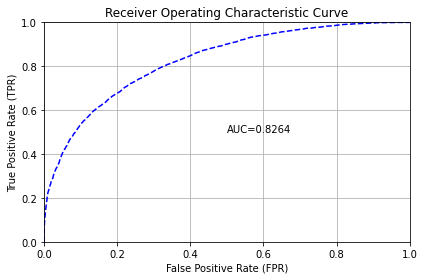

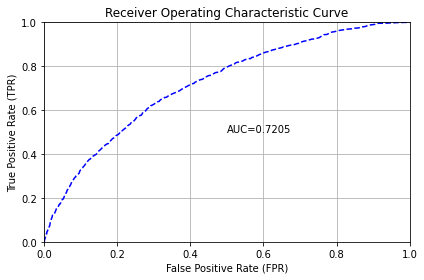

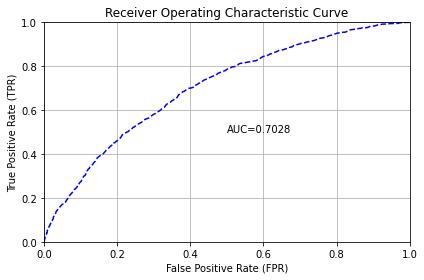

([0.00015309246785058175,
  0.00015309246785058175,
  0.00015309246785058175,
  0.00015309246785058175,
  0.0003061849357011635,
  0.000612369871402327,
  0.000612369871402327,
  0.0007654623392529087,
  0.0009185548071034905,
  0.001224739742804654,
  0.001224739742804654,
  0.0013778322106552357,
  0.0015309246785058174,
  0.0016840171463563993,
  0.0016840171463563993,
  0.001990202082057563,
  0.0021432945499081446,
  0.0021432945499081446,
  0.0022963870177587263,
  0.0022963870177587263,
  0.002449479485609308,
  0.0026025719534598897,
  0.0027556644213104714,
  0.003214941824862217,
  0.0035211267605633804,
  0.0038273116962645438,
  0.0038273116962645438,
  0.0038273116962645438,
  0.004286589099816289,
  0.004439681567666871,
  0.004745866503368034,
  0.005052051439069198,
  0.005511328842620943,
  0.005970606246172688,
  0.006276791181873852,
  0.006582976117575016,
  0.006736068585425597,
  0.007195345988977342,
  0.007501530924678506,
  0.0076546233925290875,
  0.0082669932

In [11]:
%matplotlib inline
gbm.model_performance(train).plot()
gbm.model_performance(valid).plot()
gbm.model_performance(test).plot()

In [12]:
print(gbm.model_performance(train).auc(),
      gbm.model_performance(valid).auc(),
      gbm.model_performance(test).auc())

0.8264105749871411 0.7204978140549837 0.7028282845317056


In [13]:
gbm.auc(train = True, valid = True)

{'train': 0.8264100301886944, 'valid': 0.7204978140549837}

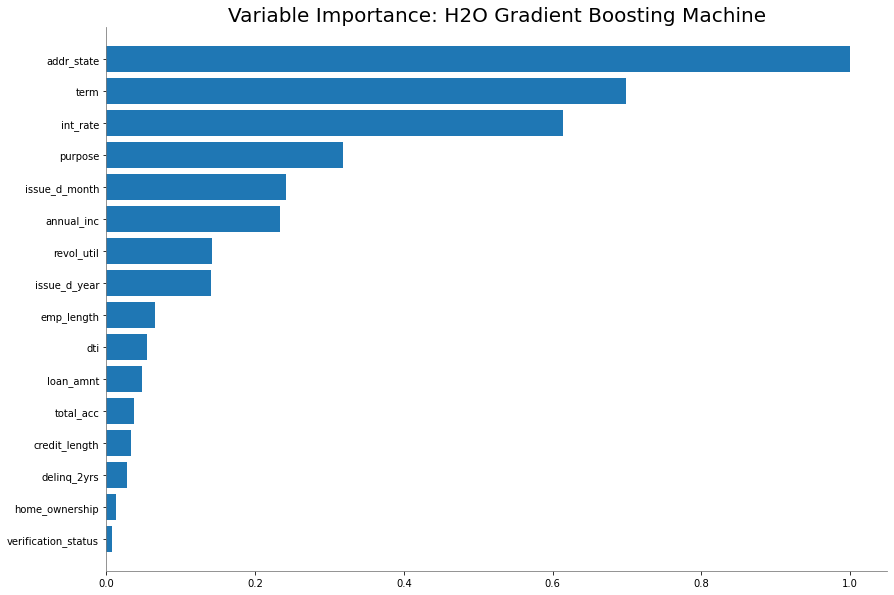

<Figure size 432x288 with 0 Axes>

In [14]:
gbm.varimp_plot(20)

### Baseline XGBoost cross-validated model

In [15]:
from h2o.estimators import H2OXGBoostEstimator

xgb = H2OXGBoostEstimator(nfolds = 5, seed = 25)
xgb.train(x = predictors,
             y = response,
             training_frame = train_cv,
             model_id = "xgb")

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  xgb


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09738327464765434
RMSE: 0.3120629337932564
LogLoss: 0.3215224017070279
Mean Per-Class Error: 0.24434949895954006
AUC: 0.8615717970571359
AUCPR: 0.6195915834235116
Gini: 0.7231435941142719

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24512140225555937: 


,,0,1,Error,Rate
0,0,23277.0,2967.0,0.1131,(2967.0/26244.0)
1,1,1894.0,3148.0,0.3756,(1894.0/5042.0)
2,Total,25171.0,6115.0,0.1554,(4861.0/31286.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.245121,0.564309,201.0
1,max f2,0.175301,0.655091,250.0
2,max f0point5,0.383148,0.619029,131.0
3,max accuracy,0.383148,0.877965,131.0
4,max precision,0.979629,1.000000,0.0
5,max recall,0.025801,1.000000,381.0
6,max specificity,0.979629,1.000000,0.0
7,max absolute_mcc,0.298915,0.482148,173.0
8,max min_per_class_accuracy,0.180918,0.775684,245.0
9,max mean_per_class_accuracy,0.187344,0.777933,240.0



Gains/Lift Table: Avg response rate: 16.12 %, avg score: 16.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.675885,5.987008,5.987008,0.964856,0.756281,0.964856,0.756281,0.059897,0.059897,498.700754,498.700754,0.059478
1,2,0.020009,0.586665,5.649991,5.818499,0.910543,0.624619,0.937700,0.690450,0.056525,0.116422,464.999056,481.849905,0.114936
2,3,0.030013,0.529442,4.956132,5.531043,0.798722,0.556887,0.891374,0.645929,0.049583,0.166006,395.613207,453.104339,0.162119
3,4,0.040018,0.491718,4.599291,5.298105,0.741214,0.509719,0.853834,0.611877,0.046013,0.212019,359.929056,429.810518,0.205046
4,5,0.050022,0.457392,4.361396,5.110763,0.702875,0.473666,0.823642,0.584235,0.043633,0.255653,336.139622,411.076339,0.245136
5,6,0.100013,0.348982,3.380260,4.245788,0.544757,0.398753,0.684244,0.491523,0.168981,0.424633,238.025953,324.578799,0.386986
6,7,0.150003,0.284982,2.313018,3.601669,0.372762,0.315193,0.580439,0.432759,0.115629,0.540262,131.301796,260.166859,0.465235
7,8,0.200026,0.240352,1.804032,3.152116,0.290735,0.261228,0.507990,0.389862,0.090242,0.630504,80.403207,215.211584,0.513182
8,9,0.300006,0.185558,1.350914,2.551843,0.217711,0.210893,0.411251,0.330219,0.135065,0.765569,35.091358,155.184302,0.555007
9,10,0.400019,0.149049,0.757539,2.103231,0.122084,0.166640,0.338953,0.289321,0.075764,0.841333,-24.246099,110.323117,0.526099




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.12431273336975646
RMSE: 0.3525801091521705
LogLoss: 0.4022541029788696
Mean Per-Class Error: 0.3429952232975969
AUC: 0.7189187452438082
AUCPR: 0.32716805754362666
Gini: 0.43783749048761633

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16414550389500632: 


,,0,1,Error,Rate
0,0,18219.0,8025.0,0.3058,(8025.0/26244.0)
1,1,1917.0,3125.0,0.3802,(1917.0/5042.0)
2,Total,20136.0,11150.0,0.3178,(9942.0/31286.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.164146,0.385993,250.0
1,max f2,0.095465,0.542320,312.0
2,max f0point5,0.288355,0.360399,166.0
3,max accuracy,0.607314,0.839737,46.0
4,max precision,0.840152,0.680000,8.0
5,max recall,0.003295,1.000000,399.0
6,max specificity,0.939076,0.999962,0.0
7,max absolute_mcc,0.210227,0.243412,216.0
8,max min_per_class_accuracy,0.151408,0.658551,260.0
9,max mean_per_class_accuracy,0.140113,0.662200,270.0



Gains/Lift Table: Avg response rate: 16.12 %, avg score: 15.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.631936,3.310696,3.310696,0.533546,0.716472,0.533546,0.716472,0.033122,0.033122,231.069622,231.069622,0.027559
1,2,0.020009,0.555294,2.715960,3.013328,0.437700,0.589496,0.485623,0.652984,0.027172,0.060294,171.596037,201.332830,0.048024
2,3,0.030013,0.506251,2.755609,2.927422,0.444089,0.531112,0.471778,0.612360,0.027568,0.087862,175.560943,192.742201,0.068962
3,4,0.040018,0.468587,2.636662,2.854732,0.424920,0.485832,0.460064,0.580728,0.026378,0.114240,163.666226,185.473207,0.088482
4,5,0.050022,0.438457,2.418592,2.767504,0.389776,0.452529,0.446006,0.555088,0.024197,0.138437,141.859245,176.750415,0.105401
5,6,0.100013,0.341827,2.190027,2.478858,0.352941,0.385863,0.399489,0.470503,0.109480,0.247917,119.002730,147.885800,0.176320
6,7,0.150003,0.284880,1.840893,2.266248,0.296675,0.311708,0.365225,0.417583,0.092027,0.339944,84.089251,126.624815,0.226433
7,8,0.200026,0.241105,1.459085,2.064393,0.235144,0.262316,0.332694,0.378753,0.072987,0.412931,45.908528,106.439294,0.253809
8,9,0.300006,0.185514,1.360832,1.829923,0.219309,0.210879,0.294907,0.322807,0.136057,0.548988,36.083218,82.992266,0.296817
9,10,0.400019,0.148663,1.201750,1.672867,0.193672,0.166058,0.269596,0.283617,0.120190,0.669179,20.175036,67.286704,0.320871




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.704838,0.047177,0.636320,0.738673,0.748106,0.724568,0.676522
1,auc,0.719197,0.009744,0.705211,0.715105,0.724675,0.730882,0.720114
2,err,0.295162,0.047177,0.363680,0.261327,0.251894,0.275432,0.323478
3,err_count,1846.800000,295.245150,2277.000000,1615.000000,1596.000000,1722.000000,2024.000000
4,f0point5,0.327258,0.018970,0.303775,0.335512,0.348669,0.337250,0.311085
5,f1,0.389864,0.008678,0.382425,0.383823,0.398644,0.400000,0.384428
6,f2,0.484844,0.027641,0.516030,0.448387,0.465341,0.491438,0.503024
7,lift_top_group,3.290391,0.583072,2.939704,2.501943,4.018812,3.508418,3.483077
8,logloss,0.402277,0.010944,0.419583,0.405969,0.395321,0.392171,0.398340
9,max_per_class_error,0.425830,0.058851,0.370996,0.494980,0.476238,0.420202,0.366733



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-06-26 09:24:41,15.468 sec,0.0,0.500000,0.693147,0.500000,0.161158,1.000000,0.838842
1,,2022-06-26 09:24:41,15.600 sec,1.0,0.430471,0.561545,0.722594,0.365732,4.230128,0.274500
2,,2022-06-26 09:24:41,15.665 sec,2.0,0.391474,0.490490,0.737972,0.386147,4.421582,0.274947
3,,2022-06-26 09:24:41,15.729 sec,3.0,0.369559,0.448750,0.743504,0.398148,4.634172,0.233523
4,,2022-06-26 09:24:41,15.794 sec,4.0,0.357053,0.422787,0.749292,0.409461,4.837185,0.236464
5,,2022-06-26 09:24:41,15.861 sec,5.0,0.349964,0.406445,0.753845,0.416903,4.956132,0.245733
6,,2022-06-26 09:24:41,15.928 sec,6.0,0.345706,0.395484,0.759461,0.423717,4.975957,0.217030
7,,2022-06-26 09:24:41,15.991 sec,7.0,0.342781,0.387510,0.765638,0.430133,4.995781,0.245637
8,,2022-06-26 09:24:41,16.054 sec,8.0,0.340918,0.382060,0.769345,0.436586,5.035430,0.192514
9,,2022-06-26 09:24:41,16.122 sec,9.0,0.339611,0.378067,0.773009,0.439885,5.078678,0.200537



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,int_rate,2615.850342,1.000000,0.189868
1,term. 36 months,1809.370605,0.691695,0.131331
2,annual_inc,1618.163452,0.618599,0.117452
3,revol_util,1352.244141,0.516942,0.098151
4,dti,960.322876,0.367117,0.069704
5,loan_amnt,817.372742,0.312469,0.059328
6,total_acc,739.453552,0.282682,0.053672
7,credit_length,625.118591,0.238973,0.045373
8,emp_length,501.169891,0.191590,0.036377
9,purpose.small_business,293.929871,0.112365,0.021335



See the whole table with table.as_data_frame()


In [16]:
xgb.auc(train = True, xval = True)

{'train': 0.8615717970571359, 'xval': 0.7189187452438082}

In [17]:
xgb.model_performance(test_cv).auc()

0.6960388575560225

In [18]:
perf = xgb.auc(train = True, xval = True)
perf["test"] = xgb.model_performance(test_cv).auc()
perf

{'train': 0.8615717970571359,
 'xval': 0.7189187452438082,
 'test': 0.6960388575560225}

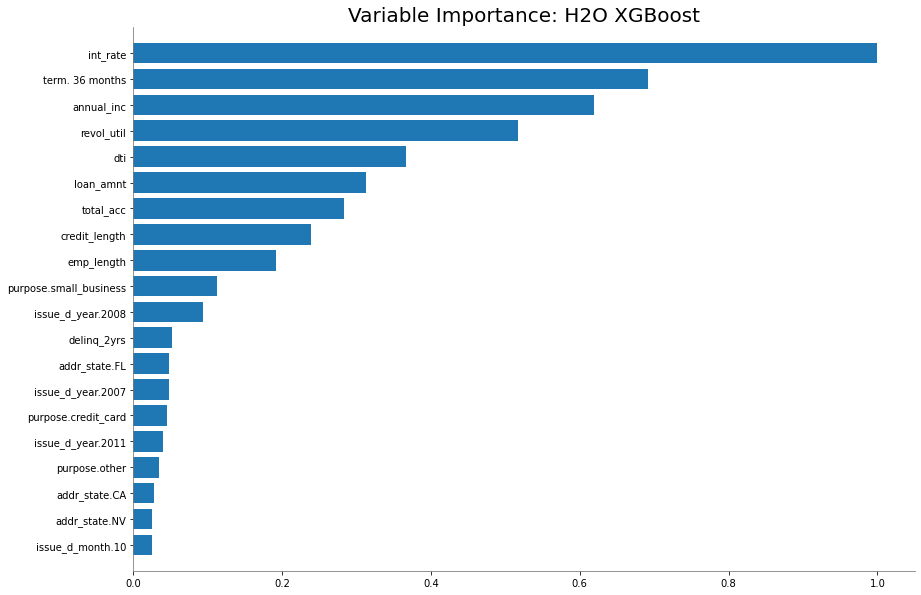

<Figure size 432x288 with 0 Axes>

In [19]:
xgb.varimp_plot(20)

## Model Optimization with Grid Search

### Step 1 - a Cartesian grid search to focus on best tree depth

In [20]:
from h2o.grid.grid_search import H2OGridSearch

hyperparams = {
    "max_depth" : list(range(2, 14, 2))
}

In [21]:
gbm_grid = H2OGradientBoostingEstimator(
    ntrees = 10000,
    stopping_metric = "AUC",
    stopping_rounds = 5,
    stopping_tolerance = 1e-4,
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    sample_rate = 0.8,
    col_sample_rate = 0.8,
    score_tree_interval = 10,
    seed = 25
)

In [22]:
grid = H2OGridSearch(
    gbm_grid,
    hyperparams,
    grid_id = "gbm_depth_grid",
    search_criteria = {"strategy": "Cartesian"}
)

In [23]:
grid.train(x = predictors,
           y = response,
           training_frame = train,
           validation_frame = valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
     max_depth               model_ids   logloss
0          4.0  gbm_depth_grid_model_2  0.397952
1          6.0  gbm_depth_grid_model_3  0.398782
2          2.0  gbm_depth_grid_model_1  0.400378
3          8.0  gbm_depth_grid_model_4  0.403103
4         10.0  gbm_depth_grid_model_5  0.412062
5         12.0  gbm_depth_grid_model_6  0.425666


In [24]:
sorted_grid = grid.get_grid(sort_by = "auc", decreasing = True)
print(sorted_grid)

     max_depth               model_ids       auc
0          4.0  gbm_depth_grid_model_2  0.727462
1          6.0  gbm_depth_grid_model_3  0.725045
2          2.0  gbm_depth_grid_model_1  0.724017
3          8.0  gbm_depth_grid_model_4  0.718107
4         10.0  gbm_depth_grid_model_5  0.705506
5         12.0  gbm_depth_grid_model_6  0.702884



### Step 2 - a random grid search to tune other hyperparameters

In [25]:
hyperparams_tune = {
    "max_depth" : list(range(2, 6, 1)),
    "sample_rate" : [x/100. for x in range(20,101)],
    "col_sample_rate" : [x/100. for x in range(20,101)],
    "min_split_improvement": [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    "strategy" : "RandomDiscrete",
    "max_runtime_secs" : 300,  
    "max_models" : 10,
    "stopping_rounds" : 5,
    "stopping_metric" : "AUC",
    "stopping_tolerance": 1e-3}

gbm_final_grid = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    score_tree_interval = 10,
    seed = 12345)

final_grid = H2OGridSearch(
    gbm_final_grid,
    hyper_params = hyperparams_tune,
    grid_id = "gbm_final_grid",
    search_criteria = search_criteria_tune)

In [26]:
final_grid.train(
    x = predictors,
    y = response,
    max_runtime_secs = 180, 
    training_frame = train,
    validation_frame = valid
)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
     col_sample_rate  max_depth  min_split_improvement  sample_rate  \
0               0.40        4.0           1.000000e-06         0.86   
1               0.22        5.0           1.000000e-06         0.60   
2               0.32        5.0           1.000000e-08         0.93   
3               0.96        4.0           1.000000e-04         0.55   
4               0.51        4.0           1.000000e-08         0.84   
5               0.97        4.0           1.000000e-04         0.81   
6               0.80        4.0           1.000000e-06         0.74   
7               0.54        3.0           0.000000e+00         0.23   
8               0.48        2.0           1.000000e-08         0.46   
9               0.84        2.0           1.000000e-04         0.58   

                 model_ids   logloss  
0   gbm_final_grid_model_4  0.395848  
1   gbm_final_grid_model_5  0.396690  
2   gb

In [27]:
grid = final_grid.get_grid(sort_by = "auc", 
                           decreasing = True)
grid

     col_sample_rate  max_depth  min_split_improvement  sample_rate  \
0               0.40        4.0           1.000000e-06         0.86   
1               0.22        5.0           1.000000e-06         0.60   
2               0.32        5.0           1.000000e-08         0.93   
3               0.96        4.0           1.000000e-04         0.55   
4               0.80        4.0           1.000000e-06         0.74   
5               0.97        4.0           1.000000e-04         0.81   
6               0.51        4.0           1.000000e-08         0.84   
7               0.48        2.0           1.000000e-08         0.46   
8               0.54        3.0           0.000000e+00         0.23   
9               0.84        2.0           1.000000e-04         0.58   

                 model_ids       auc  
0   gbm_final_grid_model_4  0.730797  
1   gbm_final_grid_model_5  0.729616  
2   gbm_final_grid_model_8  0.729200  
3   gbm_final_grid_model_1  0.727915  
4   gbm_final_grid_mode

In [28]:
best_gbm = grid.models[0]
perf = best_gbm.auc(train = True, valid = True)
perf["test"] = best_gbm.model_performance(test).auc()
perf

{'train': 0.7807350162368096,
 'valid': 0.7307965552556951,
 'test': 0.7091513855263587}

## H2O AutoML

In [29]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models = 10,
                max_runtime_secs_per_model = 60,
                exclude_algos = ["DeepLearning"],
                seed = 25)

aml.train(x = predictors, 
          y = response, 
          training_frame = train_cv)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220626_92719

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09038316997674159
RMSE: 0.3006379383523337
LogLoss: 0.30085351737166216
Null degrees of freedom: 10078
Residual degrees of freedom: 10068
Null deviance: 8742.080439644425
Residual deviance: 6064.605203177965
AIC: 6086.605203177965
AUC: 0.9130527834010211
AUCPR: 0.707835203859854
Gini: 0.8261055668020423

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25465246181267487: 


,,0,1,Error,Rate
0,0,7817.0,686.0,0.0807,(686.0/8503.0)
1,1,526.0,1050.0,0.3338,(526.0/1576.0)
2,Total,8343.0,1736.0,0.1203,(1212.0/10079.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.254652,0.634058,172.0
1,max f2,0.184496,0.725269,224.0
2,max f0point5,0.387775,0.672468,102.0
3,max accuracy,0.358300,0.892152,114.0
4,max precision,0.776200,1.000000,0.0
5,max recall,0.069308,1.000000,338.0
6,max specificity,0.776200,1.000000,0.0
7,max absolute_mcc,0.254652,0.563254,172.0
8,max min_per_class_accuracy,0.193117,0.825944,217.0
9,max mean_per_class_accuracy,0.184496,0.831134,224.0



Gains/Lift Table: Avg response rate: 15.64 %, avg score: 15.86 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010021,0.578312,6.331985,6.331985,0.990099,0.635074,0.990099,0.635074,0.063452,0.063452,533.198472,533.198472,0.063334
1,2,0.020042,0.528785,6.331985,6.331985,0.990099,0.554021,0.990099,0.594547,0.063452,0.126904,533.198472,533.198472,0.126668
2,3,0.030063,0.489327,5.635466,6.099812,0.881188,0.508036,0.953795,0.565710,0.056472,0.183376,463.546640,509.981195,0.181729
3,4,0.040083,0.456154,5.065588,5.841256,0.792079,0.470934,0.913366,0.542016,0.050761,0.234137,406.558778,484.125591,0.230021
4,5,0.050005,0.431764,4.988338,5.672026,0.780000,0.443772,0.886905,0.522523,0.049492,0.283629,398.833756,467.202608,0.276926
5,6,0.100010,0.332656,3.679838,4.675932,0.575397,0.378913,0.731151,0.450718,0.184010,0.467640,267.983795,367.593201,0.435768
6,7,0.150015,0.272569,2.943870,4.098578,0.460317,0.300143,0.640873,0.400526,0.147208,0.614848,194.387036,309.857813,0.550988
7,8,0.200020,0.235742,2.042945,3.584670,0.319444,0.252701,0.560516,0.363570,0.102157,0.717005,104.294451,258.466972,0.612807
8,9,0.300030,0.182680,1.408490,2.859276,0.220238,0.206404,0.447090,0.311181,0.140863,0.857868,40.848970,185.927638,0.661232
9,10,0.400040,0.148796,0.723278,2.325277,0.113095,0.164087,0.363591,0.274408,0.072335,0.930203,-27.672151,132.527691,0.628427




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.12179273251770549
RMSE: 0.3489881552684926
LogLoss: 0.3942064769229675
Null degrees of freedom: 31285
Residual degrees of freedom: 31275
Null deviance: 27631.81948270279
Residual deviance: 24666.287674023923
AIC: 24688.287674023923
AUC: 0.7312725181331562
AUCPR: 0.34341171061979836
Gini: 0.4625450362663124

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19382308126297784: 


,,0,1,Error,Rate
0,0,20021.0,6223.0,0.2371,(6223.0/26244.0)
1,1,2196.0,2846.0,0.4355,(2196.0/5042.0)
2,Total,22217.0,9069.0,0.2691,(8419.0/31286.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.193823,0.403373,216.0
1,max f2,0.119410,0.549065,288.0
2,max f0point5,0.290863,0.377064,144.0
3,max accuracy,0.497805,0.840919,45.0
4,max precision,0.732394,0.666667,1.0
5,max recall,0.014114,1.000000,395.0
6,max specificity,0.742406,0.999962,0.0
7,max absolute_mcc,0.193823,0.265271,216.0
8,max min_per_class_accuracy,0.162453,0.669972,245.0
9,max mean_per_class_accuracy,0.157868,0.671387,250.0



Gains/Lift Table: Avg response rate: 16.12 %, avg score: 16.12 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.528278,3.528766,3.528766,0.568690,0.581811,0.568690,0.581811,0.035303,0.035303,252.876603,252.876603,0.030159
1,2,0.020009,0.479912,3.231398,3.380082,0.520767,0.502645,0.544728,0.542228,0.032328,0.067632,223.139811,238.008207,0.056772
2,3,0.030013,0.446154,2.715960,3.158708,0.437700,0.462716,0.509052,0.515724,0.027172,0.094804,171.596037,215.870817,0.077238
3,4,0.040018,0.419840,2.478066,2.988548,0.399361,0.432675,0.481629,0.494962,0.024792,0.119595,147.806603,198.854764,0.094866
4,5,0.050022,0.398614,2.418592,2.874557,0.389776,0.408547,0.463259,0.477679,0.024197,0.143792,141.859245,187.455660,0.111785
5,6,0.100013,0.323481,2.265409,2.570080,0.365090,0.357595,0.414190,0.417656,0.113249,0.257041,126.540867,157.007998,0.187196
6,7,0.150003,0.273642,1.932144,2.357480,0.311381,0.297118,0.379928,0.377485,0.096589,0.353630,93.214365,135.747985,0.242747
7,8,0.200026,0.238260,1.589927,2.165530,0.256230,0.255040,0.348993,0.346864,0.079532,0.433161,58.992717,116.553035,0.277926
8,9,0.300006,0.189172,1.432246,1.921154,0.230818,0.211885,0.309610,0.301881,0.143197,0.576359,43.224611,92.115436,0.329445
9,10,0.400019,0.156997,1.112511,1.718977,0.179291,0.172633,0.277028,0.269566,0.111265,0.687624,11.251147,71.897748,0.342859




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.713843,0.026748,0.713281,0.744216,0.710476,0.672532,0.728711
1,auc,0.731487,0.005689,0.734386,0.735057,0.723531,0.727545,0.736915
2,err,0.286157,0.026748,0.286719,0.255784,0.289523,0.327468,0.271289
3,err_count,1791.000000,173.370990,1794.000000,1581.000000,1835.000000,2047.000000,1698.000000
4,f0point5,0.340248,0.013938,0.340502,0.354080,0.326398,0.326097,0.354162
5,f1,0.406932,0.009606,0.411417,0.408087,0.392585,0.404076,0.418493
6,f2,0.507214,0.020115,0.519642,0.481534,0.492443,0.531068,0.511383
7,lift_top_group,3.521403,0.345168,3.194129,3.303099,3.367063,4.034205,3.708517
8,logloss,0.394188,0.003908,0.390803,0.392489,0.392489,0.400807,0.394352
9,max_per_class_error,0.391527,0.046227,0.369849,0.452811,0.407000,0.328170,0.399804



See the whole table with table.as_data_frame()


### The AutoML leaderboard

In [30]:
print(aml.leaderboard)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20220626_92719,0.731273,0.394206,0.343412,0.336331,0.348988,0.121793
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_92719,0.730731,0.394483,0.342543,0.336898,0.349112,0.121879
GLM_1_AutoML_1_20220626_92719,0.722054,0.398756,0.334972,0.336681,0.350436,0.122805
GBM_2_AutoML_1_20220626_92719,0.721612,0.399207,0.328878,0.341668,0.351155,0.12331
XGBoost_3_AutoML_1_20220626_92719,0.71875,0.400415,0.327103,0.343397,0.35192,0.123848
GBM_1_AutoML_1_20220626_92719,0.718487,0.39991,0.32811,0.347017,0.351301,0.123412
GBM_3_AutoML_1_20220626_92719,0.715948,0.40247,0.317491,0.345515,0.352883,0.124526
XRT_1_AutoML_1_20220626_92719,0.709428,0.403725,0.319623,0.355387,0.352822,0.124483
GBM_4_AutoML_1_20220626_92719,0.70737,0.406149,0.313012,0.346727,0.354187,0.125448
DRF_1_AutoML_1_20220626_92719,0.702971,0.417313,0.317572,0.358231,0.354072,0.125367


#### Examining the top model

In [31]:
best = aml.leader
perf = best.auc(train = True, xval = True)
perf["test"] = best.model_performance(test_cv).auc()
perf

{'train': 0.9130527834010211,
 'xval': 0.7312725181331562,
 'test': 0.7143202325529922}

#### Examining a selected model

In [32]:
select = h2o.get_model(aml.leaderboard[2, "model_id"])
perf = select.auc(train = True, xval = True)
perf["test"] = select.model_performance(test_data=test).auc()
perf

{'train': 0.7283406906750859,
 'xval': 0.7220537547094877,
 'test': 0.7055541077792054}

## Feature engineering options

### Target encoding

In [33]:
import numpy as np

def sorted_table(colname, data=train_cv):
    tbl = data[colname].table().as_data_frame()
    tbl["Percent"] = np.round((100 * tbl["Count"]/data.nrows), 2)
    tbl = tbl.sort_values(by = "Count", ascending = 0)
    tbl = tbl.reset_index(drop = True)
    return(tbl)

In [34]:
sorted_table("purpose")

,purpose,Count,Percent
0,debt_consolidation,14484,46.30
1,credit_card,4117,13.16
2,other,3346,10.69
3,home_improvement,2287,7.31
4,major_purchase,1718,5.49
5,small_business,1448,4.63
6,car,1118,3.57
7,wedding,732,2.34
8,medical,539,1.72
9,moving,475,1.52


In [35]:
sorted_table("addr_state")

,addr_state,Count,Percent
0,CA,5559,17.77
1,NY,2956,9.45
2,FL,2285,7.30
3,TX,2179,6.96
4,NJ,1444,4.62
5,IL,1227,3.92
6,PA,1190,3.80
7,VA,1097,3.51
8,GA,1097,3.51
9,MA,1042,3.33


In [36]:
from h2o.estimators import H2OTargetEncoderEstimator

encoded_columns = ["purpose", "addr_state"]
train_cv["fold"] = train_cv.kfold_column(n_folds=5, seed=25)

In [37]:
te = H2OTargetEncoderEstimator(
    data_leakage_handling = "k_fold",
    fold_column = "fold",
    noise = 0.05,
    blending = True,
    inflection_point = 10,
    smoothing = 20
)

In [38]:
te.train(x = encoded_columns,
         y = response,
         training_frame = train_cv)

targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%
Model Details
H2OTargetEncoderEstimator :  TargetEncoder
Model Key:  TargetEncoder_model_python_1656260446753_4401


Target Encoder model summary: Summary for target encoder model


,original_names,encoded_column_names
0,purpose,purpose_te
1,addr_state,addr_state_te


In [39]:
train_te = te.transform(frame = train_cv)
test_te = te.transform(frame = test_cv, noise = 0.0)

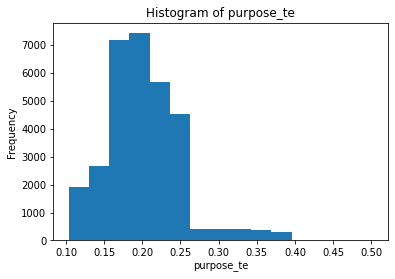

breaks,counts,mids_true,mids,widths
0.090084,nan,nan,nan,nan
0.116663,1918,0.0317527,0.103373,0.0265786
0.143241,2668,0.0450467,0.129952,0.0265786
0.16982,7172,0.0583317,0.15653,0.0265786
0.196398,7428,0.0716212,0.183109,0.0265786
0.222977,5698,0.0849099,0.209688,0.0265786
0.249555,4527,0.0982016,0.236266,0.0265786
0.276134,409,0.111497,0.262845,0.0265786
0.302713,410,0.124821,0.289423,0.0265786
0.329291,406,0.138068,0.316002,0.0265786


In [40]:
train_te["purpose_te"].hist()

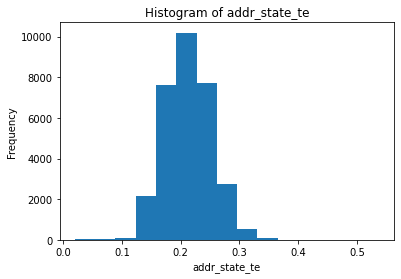

breaks,counts,mids_true,mids,widths
0.00230744,nan,nan,nan,nan
0.036859,24,-0.016122,0.0195832,0.0345515
0.0714105,47,0.00308525,0.0541347,0.0345515
0.105962,78,0.0184787,0.0886862,0.0345515
0.140513,2173,0.0357796,0.123238,0.0345515
0.175065,7625,0.0529816,0.157789,0.0345515
0.209617,10193,0.070259,0.192341,0.0345515
0.244168,7747,0.0875359,0.226892,0.0345515
0.27872,2750,0.10481,0.261444,0.0345515
0.313271,526,0.122105,0.295995,0.0345515


In [41]:
train_te["addr_state_te"].hist()

In [42]:
predictors.extend(["addr_state_te", "purpose_te"])

In [43]:
drop = ["addr_state", "purpose"]
predictors = [x for x in predictors if x not in drop]

In [44]:
transformed = predictors.copy()

train = train_te
test = test_te

In [45]:
check = H2OAutoML(max_models = 10,
                  max_runtime_secs_per_model = 60,
                  exclude_algos = ['DeepLearning'],
                  seed = 25)

check.train(x = transformed, 
            y = response, 
            training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_2_20220626_92923

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0931007103039841
RMSE: 0.3051240900092684
LogLoss: 0.3084419870665494
Null degrees of freedom: 10078
Residual degrees of freedom: 10069
Null deviance: 8742.080439644425
Residual deviance: 6217.573575287503
AIC: 6237.573575287503
AUC: 0.9002070633774524
AUCPR: 0.6851443722849822
Gini: 0.8004141267549048

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2647871061351604: 


,,0,1,Error,Rate
0,0,7878.0,625.0,0.0735,(625.0/8503.0)
1,1,633.0,943.0,0.4016,(633.0/1576.0)
2,Total,8511.0,1568.0,0.1248,(1258.0/10079.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.264787,0.599873,163.0
1,max f2,0.172290,0.705692,231.0
2,max f0point5,0.362533,0.669105,109.0
3,max accuracy,0.347921,0.891259,116.0
4,max precision,0.838449,1.000000,0.0
5,max recall,0.048870,1.000000,359.0
6,max specificity,0.838449,1.000000,0.0
7,max absolute_mcc,0.326872,0.530364,127.0
8,max min_per_class_accuracy,0.184906,0.807715,219.0
9,max mean_per_class_accuracy,0.172290,0.815963,231.0



Gains/Lift Table: Avg response rate: 15.64 %, avg score: 15.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010021,0.566503,6.331985,6.331985,0.990099,0.633194,0.990099,0.633194,0.063452,0.063452,533.198472,533.198472,0.063334
1,2,0.020042,0.512202,6.205345,6.268665,0.970297,0.536163,0.980198,0.584678,0.062183,0.125635,520.534503,526.866487,0.125164
2,3,0.030063,0.475951,6.205345,6.247558,0.970297,0.492265,0.976898,0.553874,0.062183,0.187817,520.534503,524.755826,0.186994
3,4,0.040083,0.445185,4.938948,5.920406,0.772277,0.459896,0.925743,0.530380,0.049492,0.237310,393.894808,492.040571,0.233781
4,5,0.050005,0.414690,4.604619,5.659337,0.720000,0.428290,0.884921,0.510124,0.045685,0.282995,360.461929,465.933698,0.276174
5,6,0.100010,0.321624,3.705216,4.682277,0.579365,0.364085,0.732143,0.437104,0.185279,0.468274,270.521614,368.227656,0.436521
6,7,0.150015,0.268821,2.322105,3.895553,0.363095,0.292406,0.609127,0.388871,0.116117,0.584391,132.210464,289.555258,0.514886
7,8,0.200020,0.229574,1.890675,3.394333,0.295635,0.248156,0.530754,0.353693,0.094543,0.678934,89.067536,239.433328,0.567679
8,9,0.300030,0.179110,1.459246,2.749304,0.228175,0.202690,0.429894,0.303358,0.145939,0.824873,45.924608,174.930421,0.622121
9,10,0.400040,0.148165,0.856514,2.276107,0.133929,0.163136,0.355903,0.268303,0.085660,0.910533,-14.348600,127.610666,0.605111




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.12220611040089015
RMSE: 0.34957990560226737
LogLoss: 0.3956718622238385
Null degrees of freedom: 31285
Residual degrees of freedom: 31276
Null deviance: 27631.81948270279
Residual deviance: 24757.979763070023
AIC: 24777.979763070023
AUC: 0.7273109545418244
AUCPR: 0.3402176090437699
Gini: 0.45462190908364875

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1889448530334387: 


,,0,1,Error,Rate
0,0,19703.0,6541.0,0.2492,(6541.0/26244.0)
1,1,2144.0,2898.0,0.4252,(2144.0/5042.0)
2,Total,21847.0,9439.0,0.2776,(8685.0/31286.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.188945,0.400249,216.0
1,max f2,0.108611,0.545503,296.0
2,max f0point5,0.288848,0.366710,145.0
3,max accuracy,0.521351,0.840472,35.0
4,max precision,0.734516,0.666667,0.0
5,max recall,0.010295,1.000000,395.0
6,max specificity,0.734516,0.999962,0.0
7,max absolute_mcc,0.199046,0.261069,208.0
8,max min_per_class_accuracy,0.161365,0.666402,241.0
9,max mean_per_class_accuracy,0.154751,0.666809,247.0



Gains/Lift Table: Avg response rate: 16.12 %, avg score: 16.12 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.521499,3.548591,3.548591,0.571885,0.575495,0.571885,0.575495,0.035502,0.035502,254.859056,254.859056,0.030396
1,2,0.020009,0.472659,2.854732,3.201661,0.460064,0.495355,0.515974,0.535425,0.028560,0.064062,185.473207,220.166132,0.052516
2,3,0.030013,0.439942,3.152100,3.185141,0.507987,0.455061,0.513312,0.508637,0.031535,0.095597,215.210000,218.514088,0.078183
3,4,0.040018,0.415806,2.577189,3.033153,0.415335,0.427472,0.488818,0.488346,0.025783,0.121380,157.718868,203.315283,0.096994
4,5,0.050022,0.395482,2.517715,2.930065,0.405751,0.405423,0.472204,0.471761,0.025188,0.146569,151.771509,193.006528,0.115095
5,6,0.100013,0.320398,2.158288,2.544300,0.347826,0.354955,0.410035,0.413377,0.107894,0.254463,115.828777,154.429985,0.184123
6,7,0.150003,0.271648,1.793283,2.294014,0.289003,0.294726,0.369700,0.373835,0.089647,0.344109,79.328322,129.401432,0.231398
7,8,0.200026,0.236295,1.720769,2.150657,0.277316,0.253307,0.346596,0.343693,0.086077,0.430186,72.076905,115.065720,0.274379
8,9,0.300006,0.188913,1.422328,1.907932,0.229220,0.210201,0.307479,0.299205,0.142205,0.572392,42.232751,90.793237,0.324716
9,10,0.400019,0.157103,1.062934,1.696666,0.171301,0.172355,0.273432,0.267490,0.106307,0.678699,6.293431,69.666598,0.332220




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.720449,0.024805,0.743328,0.740980,0.712370,0.682451,0.723119
1,auc,0.727309,0.009378,0.732299,0.735488,0.712052,0.724813,0.731893
2,err,0.279551,0.024805,0.256673,0.259020,0.287630,0.317549,0.276881
3,err_count,1749.600000,161.073900,1606.000000,1601.000000,1823.000000,1985.000000,1733.000000
4,f0point5,0.340351,0.016975,0.355215,0.356514,0.319754,0.325344,0.344927
5,f1,0.403140,0.013754,0.413440,0.414625,0.381405,0.398303,0.407926
6,f2,0.494979,0.014689,0.494496,0.495370,0.472507,0.513442,0.499080
7,lift_top_group,3.523415,0.281544,3.593396,3.403193,3.169000,3.938152,3.513331
8,logloss,0.395671,0.004160,0.390938,0.392712,0.396704,0.401724,0.396277
9,max_per_class_error,0.415485,0.030168,0.431156,0.430723,0.438000,0.363988,0.413556



See the whole table with table.as_data_frame()


In [46]:
check.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_2_20220626_92923,0.727311,0.395672,0.340218,0.337233,0.34958,0.122206
StackedEnsemble_BestOfFamily_1_AutoML_2_20220626_92923,0.726592,0.39603,0.339062,0.341232,0.349742,0.12232
GBM_1_AutoML_2_20220626_92923,0.720637,0.398651,0.331034,0.34507,0.350867,0.123107
GBM_2_AutoML_2_20220626_92923,0.720581,0.399222,0.329524,0.343516,0.351132,0.123293
GBM_3_AutoML_2_20220626_92923,0.719015,0.399807,0.328291,0.347402,0.351491,0.123546
GLM_1_AutoML_2_20220626_92923,0.71542,0.401308,0.32881,0.347501,0.351439,0.123509
XGBoost_3_AutoML_2_20220626_92923,0.714073,0.40222,0.324849,0.346374,0.352513,0.124266
GBM_4_AutoML_2_20220626_92923,0.711131,0.404136,0.315467,0.351635,0.353487,0.124953
DRF_1_AutoML_2_20220626_92923,0.704524,0.412281,0.311433,0.354219,0.354566,0.125717
XRT_1_AutoML_2_20220626_92923,0.703814,0.407348,0.313046,0.355862,0.354228,0.125478


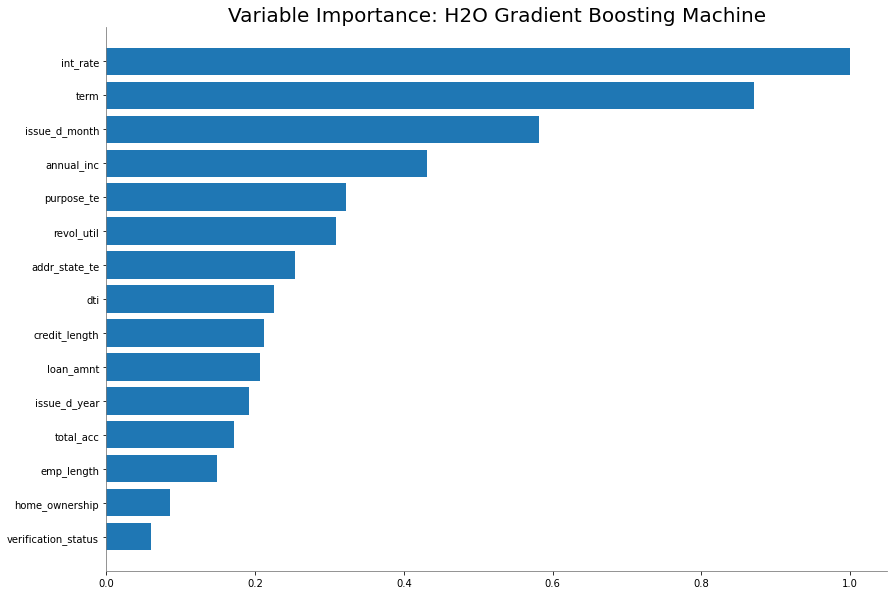

<Figure size 432x288 with 0 Axes>

In [47]:
check_gbm = h2o.get_model(check.leaderboard[2, 'model_id'])
check_gbm.varimp_plot(15)

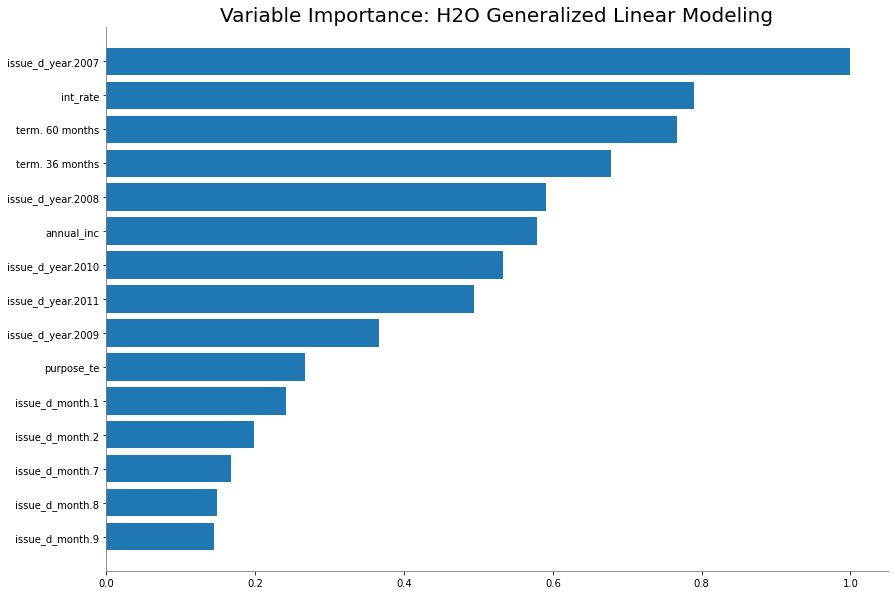

<Figure size 432x288 with 0 Axes>

In [48]:
check_xgb = h2o.get_model(check.leaderboard[5, 'model_id'])
check_xgb.varimp_plot(15)

In [49]:
h2o.cluster().shutdown(prompt = True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_bc3d closed.
